In [1]:
#importing the required libraries and packages
import pandas as pd
import re
import pprint
import numpy as np
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk import bigrams, trigrams
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from pprint import pprint
from nltk.probability import FreqDist
import seaborn as sns
import nltk
import gensim
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.metrics import confusion_matrix

unable to import 'smart_open.gcs', disabling that module


In [2]:
#reading the dataset using pandas dataframe
read_train = 'english_dataset.tsv'
read_test = 'hasoc2019_en_test-2919.tsv'
train = pd.read_csv(read_train, sep='\t')
test = pd.read_csv(read_test, sep='\t')

In [3]:
#user defined method to normalize text
def normalize_column(input_text):
    l = 0
    for i in input_text:
        if i == "NOT":
            train["task_1"][l] = 0
        else:
            train["task_1"][l] = 1
        l += 1
    return train["task_1"]


In [4]:
train["task_1"]=normalize_column(train["task_1"])

In [5]:
#checking the dataframe after normalization
train[train["task_1"]== 1].head(10)

,text_id,text,task_1,task_2,task_3
1,hasoc_en_2,@politico No. We should remember very clearly ...,1,HATE,TIN
7,hasoc_en_8,#ADOS #trendingnow #blacklivesmatter #justice ...,1,PRFN,TIN
11,hasoc_en_12,I don’t know how much more I can take! 45 is a...,1,HATE,TIN
15,hasoc_en_16,Good work @ICC keep going just destroy the who...,1,PRFN,TIN
23,hasoc_en_24,#ShameOnICC 1. ICC on Dhoni's gloves ...,1,HATE,TIN
27,hasoc_en_28,Disgusting! And they don’t change their cultur...,1,HATE,TIN
32,hasoc_en_33,@realDonaldTrump fuck you and go fuck yourself...,1,PRFN,TIN
34,hasoc_en_35,"@TheRealOJ32 Of all the retired NFL players, w...",1,HATE,TIN
43,hasoc_en_44,@Werdnat This crazy Manbaby will probably pain...,1,PRFN,TIN
44,hasoc_en_45,This is everything. #fucktrump https://t.co/e2...,1,PRFN,TIN


In [6]:
train.shape, test.shape

((5852, 5), (1153, 5))

In [7]:
train["task_1"].value_counts()

0    3591
1    2261
Name: task_1, dtype: int64

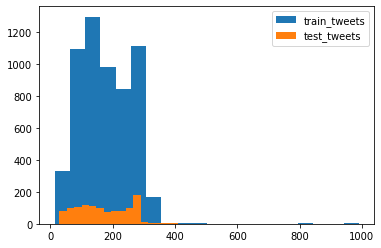

In [8]:
#Histogram for trainig tweets and test tweets
length_train = train['text'].str.len()
length_test = test['text'].str.len()

plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test, bins=20, label="test_tweets")
plt.legend()
plt.show()

In [9]:
#user defined method to remove @ from user handles
def remove_pattern(input_text, pattern):
    k = 0
    for j in input_text:
        r = re.findall(pattern, j)
        for i in r:
            j = re.sub(i, "", j)
            train["text"][k] = j
        k += 1
    return train["text"]


pat =  "@[\w]*"
processed_text = (remove_pattern(train["text"], pat))

In [10]:
pprint(processed_text)

0       #DhoniKeepsTheGlove | WATCH: Sports Minister K...
1        No. We should remember very clearly that #Ind...
2        Guess who would be the winner of this #CWC19?...
3       Corbyn is too politically intellectual for #Bo...
4       All the best to #TeamIndia for another swimmin...
5         I hope you remembered to wipe the blood off ...
6        Latest design of #WC2019 trophy. #CWC2019 #CW...
7       #ADOS #trendingnow #blacklivesmatter #justice ...
8       Thanks for your support! Wow 600k. Graffiti ha...
9       By wearing the #BalidaanBadge over his gloves ...
10      Mahendra Singh Dhoni's love for the Nation, Ar...
11      I don’t know how much more I can take! 45 is a...
12      #ShameOnICC WINNER TEAM-RAIN  ICC RUN UP TEAM-...
13                  Grevious assault on jr doctors in ...
14      ICC denies request from BCCI to allow MSD wear...
15      Good work  keep going just destroy the whole f...
16      Wow, you're full of it    #BorisJohnsonShouldN...
17      All In

In [11]:
#Removing everything except alphabet and hashtag and converting everything to lower case
processed_text = processed_text.str.replace("[^a-zA-Z#]", " ")
processed_text = processed_text.str.lower()
print(processed_text)

0       #dhonikeepstheglove   watch  sports minister k...
1        no  we should remember very clearly that #ind...
2        guess who would be the winner of this #cwc   ...
3       corbyn is too politically intellectual for #bo...
4       all the best to #teamindia for another swimmin...
5         i hope you remembered to wipe the blood off ...
6        latest design of #wc     trophy  #cwc     #cw...
7       #ados #trendingnow #blacklivesmatter #justice ...
8       thanks for your support  wow    k  graffiti ha...
9       by wearing the #balidaanbadge over his gloves ...
10      mahendra singh dhoni s love for the nation  ar...
11      i don t know how much more i can take     is a...
12      #shameonicc winner team rain  icc run up team ...
13                  grevious assault on jr doctors in ...
14      icc denies request from bcci to allow msd wear...
15      good work  keep going just destroy the whole f...
16      wow  you re full of it    #borisjohnsonshouldn...
17      all in

In [12]:
#Removing stopwords using lambda function
processed_text = processed_text.apply(lambda x: " ".join(w for w in x.split() if w not in stopwords.words('english')))

In [13]:
#Tokeizing and stemming tweets
tokenized_tweet = processed_text.apply(lambda x: x.split())

stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])


In [14]:
pprint(tokenized_tweet)

0       #dhonikeepstheglov watch sport minist kiren ri...
1       rememb clearli #individu admit treason #trumpi...
2       guess would winner #cwc team get maximum point...
3       corbyn polit intellectu #borisjohnsonshouldnot...
4       best #teamindia anoth swim competit sunday #pa...
5       hope rememb wipe blood pic taken #bloodonhisha...
6       latest design #wc trophi #cwc #cwc #shameonicc...
7       #ado #trendingnow #blacklivesmatt #justic #fuc...
8       thank support wow k graffiti massiv impact now...
9       wear #balidaanbadg glove shown love amp respec...
10      mahendra singh dhoni love nation arm forc sold...
11      know much take compuls liar #trump hour #trump...
12      #shameonicc winner team rain icc run team rain...
13      greviou assault jr doctor medic colleg wb acti...
14      icc deni request bcci allow msd wear glove arm...
15      good work keep go destroy whole fuck world cup...
16      wow full #borisjohnsonshouldnotbepm #kickthemo...
17      indian

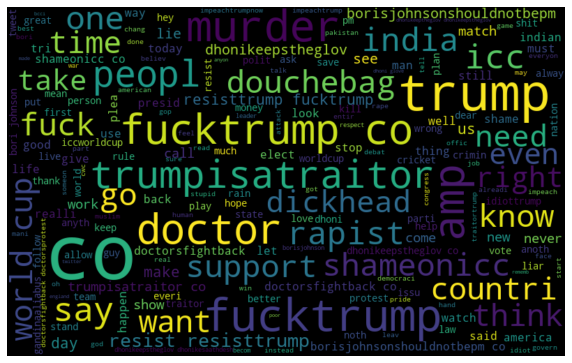

In [15]:
#Creating word cloud- some issues with repeating words
all_words = ' '.join([text for text in tokenized_tweet])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

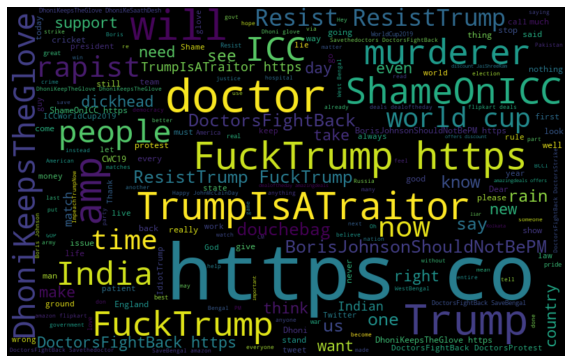

In [16]:
positive_words = ' '.join([text for text in train['text'][train['task_1'] == 0]])
wordcloud_positive = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis('off')
plt.show()

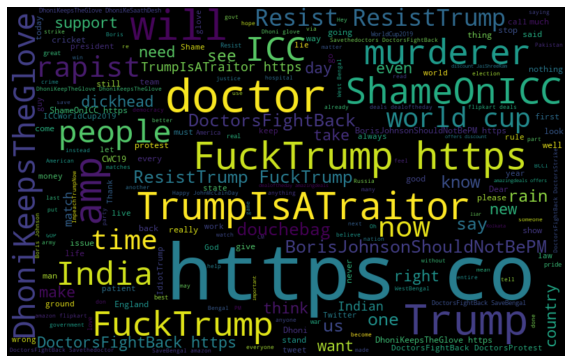

In [17]:
negative_words = ' '.join([text for text in train['text'][train['task_1'] == 1]])
wordcloud_negative = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis('off')
plt.show()

In [18]:
#Extracting hashtags for positive and negative tweets
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [19]:
HT_positive = hashtag_extract(train['text'][train['task_1'] == 1])

# extracting hashtags from hate tweets
HT_negative = hashtag_extract(train['text'][train['task_1'] == 0])

# unnesting list
HT_positive = sum(HT_positive,[])
HT_negative = sum(HT_negative,[])

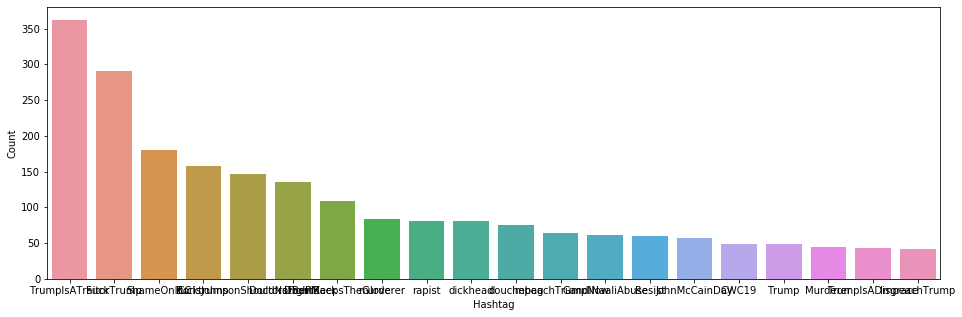

In [20]:
#Creating a frequency distribution of 20 most frequent hashtags
a = FreqDist(HT_positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

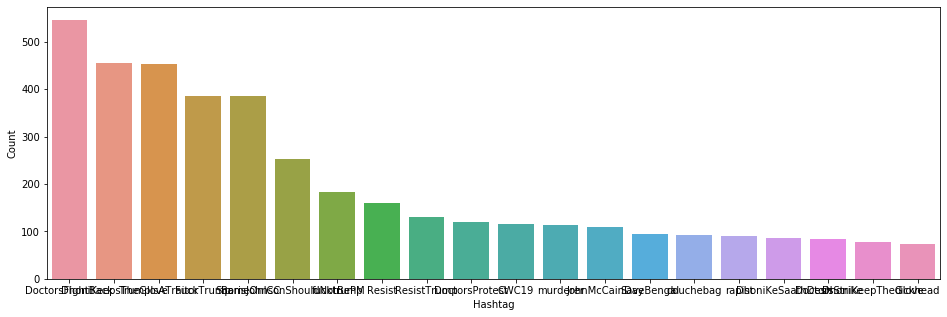

In [21]:
a = FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [22]:
#bag-of-words
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vect
orizer.fit_transform(train["text"])
bow.shape

NameError: name 'bow_vect' is not defined

In [ ]:
#tfidf
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(train["text"])
tfidf.shape

In [ ]:
#training word 2 vector model
tokenized_tweet = train["text"].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train["text"]), epochs=20)

In [ ]:
model_w2v.wv.most_similar(positive="doctor")

In [ ]:
model_w2v.wv.most_similar(positive="trump")

In [ ]:
model_w2v['trump']

In [ ]:
len(model_w2v['trump']) 

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

In [ ]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

In [ ]:
labeled_tweets = add_label(tokenized_tweet)

In [ ]:
labeled_tweets[:6]

In [ ]:
#doc 2 vector model
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

In [ ]:
model_d2v.train(labeled_tweets, total_examples= len(train["text"]), epochs=15)

In [ ]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(train)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))
    
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    bow, train["task_1"], test_size=0.3, random_state=1)
X_train=X_train.astype('int')
X_test=X_test.astype('int')
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [ ]:
#Multinomial Naive Bias classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

In [ ]:
train_bow = bow[:5852,:]
test_bow = bow[5852:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train["task_1"],  
                                                          random_state=42, 
                                                          test_size=0.3)
xtrain_bow=xtrain_bow.astype('int')
xvalid_bow=xvalid_bow.astype('int')
ytrain=ytrain.astype('int')
yvalid=yvalid.astype('int')

In [ ]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

In [ ]:
train_tfidf = tfidf[:5852,:]
test_tfidf = tfidf[5852:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

In [ ]:
lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

In [ ]:
#word 2 vector
train_w2v = wordvec_df.iloc[:5852,:]
test_w2v = wordvec_df.iloc[5852:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

In [ ]:
lreg.fit(xtrain_w2v, ytrain)

prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

In [ ]:
train_d2v = docvec_df.iloc[:5852,:]
test_d2v = docvec_df.iloc[5852:,:]

xtrain_d2v = train_d2v.iloc[ytrain.index,:]
xvalid_d2v = train_d2v.iloc[yvalid.index,:]

In [ ]:
lreg.fit(xtrain_d2v, ytrain)

prediction = lreg.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

In [ ]:
#Support Vector Machine
from sklearn import svm

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)

prediction = svc.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

In [ ]:

svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)

prediction = svc.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain)

prediction = svc.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_d2v, ytrain)

prediction = svc.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain)

prediction = rf.predict(xvalid_bow)
f1_score(yvalid, prediction)

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain)

prediction = rf.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

In [ ]:

rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain)

prediction = rf.predict(xvalid_w2v)
f1_score(yvalid, prediction)

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_d2v, ytrain)

prediction = rf.predict(xvalid_d2v)
f1_score(yvalid, prediction)

In [ ]:
#XGBoost classifier
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain)
prediction = xgb_model.predict(xvalid_bow)
f1_score(yvalid, prediction)

In [ ]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain)

prediction = xgb.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

In [ ]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain)

In [ ]:
prediction = xgb.predict(xvalid_w2v)
f1_score(yvalid, prediction)

In [ ]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_d2v, ytrain)

In [ ]:
prediction = xgb.predict(xvalid_d2v)
f1_score(yvalid, prediction)

In [ ]:
#Confusion Matrix
confusion_matrix(yvalid,prediction)